In [150]:
#get dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torch
import keras
import tensorflow as tf
import os
import random


from keras import backend as K
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
import keras_tuner as kt

from preprocessing import scale_data10
from preprocessing import generate_balanced_data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score

In [151]:
#avoid randomness
seed = 0
random.seed(seed)
np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

#remove/comment out this for much greater speed, but non-deterministic results
# Attempt to make keras deterministic
tf.config.experimental.enable_op_determinism()
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Clear previous sessions, important for reproducability
tf.keras.backend.clear_session()
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [152]:
#Load data
dataset = np.load("../data/dataset.npz",)
X, y = dataset["X"], dataset["y"]

#split data
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,train_size=.7,random_state=seed)
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test, train_size=.5, random_state=seed)

#print(X_train.shape,y_train.shape)
X_train_aug, y_train_aug = generate_balanced_data(X_train, y_train, seed=seed)

#reshape
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 20, 20, 1)
X_val = X_val.reshape(X_val.shape[0], 20, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 20, 1)

#scale (simple)
X_train_aug = X_train_aug/255
X_val = X_val/255
X_test = X_test/255


y_train_aug = keras.utils.to_categorical(y_train_aug, num_classes=17)
y_val = keras.utils.to_categorical(y_val, num_classes=17)
y_test = keras.utils.to_categorical(y_test, num_classes=17)

In [153]:
# Helper function for LeNet style CNN model
def LeNetCNN(hparam):
    #optimizer = Adam(learning_rate=learning_rate)
    
    #def hparams
    hparam_n_filter_1 = hparam.Int("Number of Filters (1)", min_value = 128, max_value = 512, step = 2, sampling = "log")
    hparam_n_filter_2 = hparam.Int("Number of Filters (2)", min_value = 128, max_value = 512, step = 2, sampling = "log")
    hparam_learning_rate = hparam.Float("Learning Rate", min_value = 0.001, max_value = .1, step = 10, sampling="log")
    hparam_activation = hparam.Choice("Actrivation function", values=["relu","tanh"])
    hparam_units = hparam.Int("Units (dense layer)", min_value = 2048, max_value = 4096, step = 2, sampling = "log")
    hparam_droprate = hparam.Float("Dropout Rate", min_value = .3, max_value = .7, step = .2)
    
    model = keras.Sequential()
    
    #input layer
    model.add(Convolution2D(filters=hparam_n_filter_1,
                            kernel_size=(3,3),
                            activation=hparam_activation,
                            input_shape = (20,20,1)))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(filters=hparam_n_filter_2,
                            kernel_size=(3,3),
                            activation=hparam_activation, input_shape = (20,20,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #flatten output
    model.add(Flatten())
    model.add(Dropout(rate=hparam_droprate))
    model.add(Dense(units=hparam_units, activation=hparam_activation))
    #output layer (softmax for probas)
    model.add(Dense(17,activation="softmax"))

    model.compile(optimizer=Adam(learning_rate=hparam_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [154]:
# #AlexNet cnn
# def AlexNetCnn (hparam):

#     hparam_n_filter_1 = hparam.Int("Number of Filters (1)", min_value = 64, max_value = 512, step = 2, sampling = "log")
#     hparam_n_filter_1 = hparam.Int("Number of Filters (2)", min_value = 64, max_value = 512, step = 2, sampling = "log")
#     hparam_pool_size = hparam.Choice("Pool Size", values=[2])
#     hparam_learning_rate = hparam.Float("Learning Rate", min_value = 0.00001, max_value = 1, step = 10, sampling="log")
#     hparam_activation = hparam.Choice("Actrivation function", values=["relu","tanh"])
#     hparam_kernel_size = hparam.Choice("Kernel Size", values=[3,5])
#     hparam_units = hparam.Int("Units (dense layer)", min_value = 1024, max_value = 4096, step = 2, sampling = "log")
#     hparam_droprate = hparam.Float("Dropout Rate", min_value = 0, max_value = .8, step = .2)



#     model = keras.Sequential()
#     #input
#     model.add(Convolution2D(padding="same", filters=hparam_n_filter_1,kernel_size = (3,3),
#                             input_shape = (20,20,1)))

#     model.add(MaxPooling2D(pool_size=(hparam_pool_size,hparam_pool_size)))
#     model.add(Convolution2D(padding="same", filters=hparam_n_filter_1, kernel_size = (hparam_kernel_size,hparam_kernel_size),
#               activation = hparam_activation))
#     model.add(MaxPooling2D(pool_size=(hparam_pool_size,hparam_pool_size)))
    
#     model.add(Convolution2D(padding="same", filters=hparam_n_filter_1, kernel_size = (hparam_kernel_size,hparam_kernel_size),
#               activation = hparam_activation))
#     model.add(Convolution2D(padding="same", filters=hparam_n_filter_1, kernel_size = (hparam_kernel_size,hparam_kernel_size),
#               activation = hparam_activation))

#     model.add(Convolution2D(padding="same", filters=hparam_n_filter_1, kernel_size = (hparam_kernel_size,hparam_kernel_size),
#               activation = hparam_activation))
#     model.add(MaxPooling2D(pool_size=(hparam_pool_size,hparam_pool_size)))

#     model.add(Flatten())
#     model.add(Dense(units = hparam_units, activation = hparam_activation))
#     model.add(Dropout(rate=hparam_droprate))

#     model.add(Dense(units = hparam_units, activation = hparam_activation))
#     model.add(Dropout(rate=hparam_droprate))
    
#     model.add(Dense(units = hparam_units, activation = hparam_activation))
#     model.add(Dropout(rate=hparam_droprate))

#     #output layer
#     model.add(Dense(17,activation="softmax"))

#     model.compile(optimizer=Adam(learning_rate=hparam_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

#     return model


In [155]:
# function to skip searching for "bad combos"(low potential, get out >:(! )

# Define a callback class to work with keras tuner
class SkipLowAcc (keras.callbacks.Callback):
    #Callback that ends if val_acc is below given threshold
    def __init__ (self, threshold):
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if (val_acc is not None) and (val_acc < self.threshold):
            print(f"ERROR\n current val_acc = {val_acc} < {self.threshold}")
            self.model.stop_training = True



In [156]:
tuner = kt.Hyperband(
    hypermodel=LeNetCNN,
    objective='val_accuracy',
    max_epochs=10,
    seed = seed,
    overwrite = True,
    project_name = "HyperTuning"
)

tunerRandomSearch = kt.RandomSearch(
    hypermodel = LeNetCNN,
    objective = kt.Objective('val_accuracy', 'max'),
    #max_trials=
    seed = seed,
    project_name = "HyperTuningRS",
    overwrite = True,
    max_trials = 3
)

# Make training faster by skiping bad combos:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=0,
    mode = "max",
    baseline = .8,
    verbose = 1
)

skip_low = SkipLowAcc(threshold=.8)

# tuner.search(X_train_aug,y_train_aug, validation_data = (X_val,y_val),epochs=10,callbacks=[skip_low])
# best_hps = tuner.get_best_hyperparameters()[0]
tunerRandomSearch.search(X_train_aug,y_train_aug, validation_data = (X_val,y_val),epochs=10,callbacks=[skip_low])
best_hps = tunerRandomSearch.get_best_hyperparameters()[0]



Trial 3 Complete [00h 00m 30s]
val_accuracy: 0.0738983079791069

Best val_accuracy So Far: 0.9755932092666626
Total elapsed time: 00h 11m 00s


In [157]:
print (best_hps.values)

{'Number of Filters (1)': 128, 'Number of Filters (2)': 128, 'Learning Rate': 0.001, 'Actrivation function': 'relu', 'Units (dense layer)': 2048, 'Dropout Rate': 0.3}


In [158]:
best_cnn = tunerRandomSearch.get_best_models()[0]
best_cnn.save("best_model.keras")



#score = accuracy_score(y_test,y_pred)
#print(f"accuracy_score (on test): {score:.2f}")0.9701896905899048 0.9701896905899048

In [159]:
# import keras.saving


# model = keras.models.load_model("best_model.keras")

# score = model.evaluate(X_test,y_test)

# print(f"Loss on test data: {score[0]}, Accuracy: {score[1]}")


In [167]:
#test cell
# best_cnn = keras.models.load_model('best_model.h5')
#best_cnn.save('best_model.h5')

score = best_cnn.evaluate(X_test,y_test)

print(f"Loss on test data: {score[0]}, Accuracy: {score[1]}")

47/47 [==============================] - 1s 11ms/step - loss: 0.0911 - accuracy: 0.9729
Loss on test data: 0.09112226963043213, Accuracy: 0.9728997349739075


47/47 [==============================] - 1s 11ms/step
------------------------------ SVM CMatrix ------------------------------


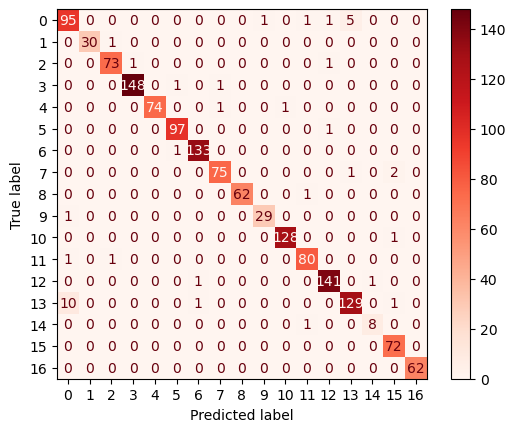

In [161]:
#workaround to get preds in list form
y_pred = best_cnn.predict(X_test)
y_pred_list = np.argmax(y_pred,axis=1)
y_test_list = np.argmax(y_test,axis=1)

print(30*"-","SVM CMatrix",30*"-")
conf_matrix = confusion_matrix(y_test_list, y_pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=cm.Reds)
plt.show()

In [162]:
def get_label(l):
    if l <10:
        return l
    return names[l]

names = {
    10 : "A",
    11 : "B",
    12 : "C",
    13 : "D",
    14 : "E",
    15 : "F",
    16 : "G"

}

/var/folders/2g/d4z1y5l52h989s4x4ddwgkx80000gn/T/ipykernel_13811/1442729582.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  wrongPred = X_val[y_pred != y_val]


(1475, 20, 20, 1)
1476
(1, 1475, 20, 20, 1)


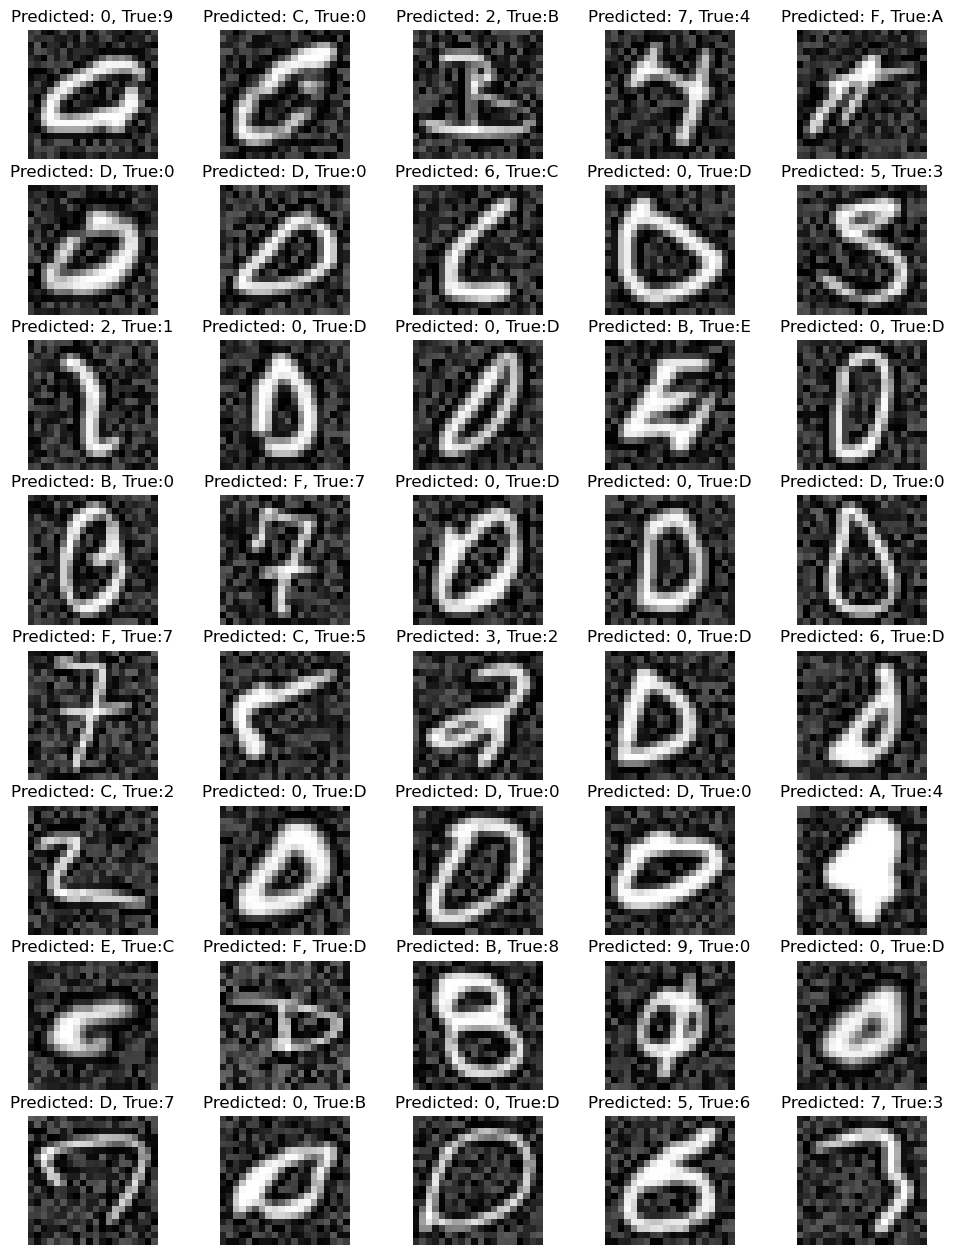

In [163]:
# fig = plt.figure(figsize=(12, 48))
# wrongPred = X_test[y_pred_list != y_test_list]
# print(X_val.shape)
# print(len(y_pred))
# print(wrongPred.shape)
# cols = 7
# rows = 10
# count = 1
# plt.imshow(X_val[0], cmap="gray")
# plt.show()
fig = plt.figure(figsize=(12, 48))
wrongPred = X_val[y_pred != y_val]
print(X_val.shape)
print(len(y_pred))
print(wrongPred.shape)
cols = 5
rows = 24
count = 1

for idx in range(len(y_pred_list)):
    if(y_pred_list[idx] != y_test_list[idx]):
        fig.add_subplot(rows, cols, count)
        plt.axis('off') 
        #pred_lab = 
        plt.title(f"Predicted: {get_label(y_pred_list[idx])}, True:{get_label(y_test_list[idx])}") 
        plt.imshow(X_test[idx], cmap="gray")
        #print("Predicted",y_pred[idx], " vs true value:",y_val[idx])
        #print("idx = ", idx,". count = ", count)
        #fig.set_label(f'Predicted: {y_pred[idx]}, True:{y_val[idx]}')
        count+=1
    

plt.show()





In [164]:
# #same but with alexnet ;-)
# tuner_alex = kt.Hyperband(
#     hypermodel=AlexNetCnn,
#     objective='val_accuracy',
#     max_epochs=10,
#     #overwrite = True
# )

# tuner_alex.search(X_train_aug,y_train_aug, validation_data = (X_val,y_val))
# best_hps = tuner_alex.get_best_hyperparameters()[0]


In [165]:
# best_cnn = tuner.get_best_models()[0]

# score = best_cnn.evaluate(X_test,y_test)

# print(f"Loss on test data: {score[0]}, Accuracy: {score[1]}")